In [1]:
!pip install backtrader[plotting]

     |████████████████████████████████| 419kB 10.9MB/s 


In [3]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import matplotlib.pyplot as plt

# Import the backtrader platform
import backtrader as bt


In [6]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class RSI(bt.Strategy):
    params = (
        ('maperiod', 15),('low_RSI',30),('high_RSI',70)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.RSI = bt.indicators.RSI_SMA(
            self.datas[0], period=self.params.maperiod)
        
        self.inc_=None
        self.dec_=None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            if self.RSI < self.params.low_RSI :

                # Long Position
                self.log('Long-BUY, %.2f' % self.dataclose[0])
                self.inc_=True
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

            if self.RSI > self.params.high_RSI :
                # Short Position
                self.log('Short-SELL, %.2f' % self.dataclose[0])
                self.dec_=True
                self.order = self.sell()

        else:

            if self.RSI > self.params.high_RSI and self.inc_ :
                # Exit Long Position
                self.log('SELL, %.2f' % self.dataclose[0])
                self.inc_=None
                self.order = self.sell()
            if self.RSI < self.params.low_RSI and self.dec_:

                # Exit Short Position
                self.log('BUY, %.2f' % self.dataclose[0])
                self_dec=None
                self.order = self.buy()


Starting Portfolio Value: 10000.00
2018-02-02, Long-BUY, 38.61
2018-02-05, BUY EXECUTED, Price: 38.28, Cost: 3828.00, Comm 0.00
2018-02-26, SELL, 43.23
2018-02-27, SELL EXECUTED, Price: 43.26, Cost: 3828.00, Comm 0.00
2018-02-27, Short-SELL, 43.09
2018-02-28, SELL EXECUTED, Price: 43.30, Cost: -4330.00, Comm 0.00
2018-03-23, BUY, 39.84
2018-03-26, BUY EXECUTED, Price: 40.60, Cost: -4330.00, Comm 0.00
2018-05-10, Short-SELL, 45.91
2018-05-11, SELL EXECUTED, Price: 45.95, Cost: -4595.00, Comm 0.00
2018-06-25, BUY, 44.17
2018-06-26, BUY EXECUTED, Price: 44.37, Cost: -4595.00, Comm 0.00
2018-06-26, Long-BUY, 44.72
2018-06-27, BUY EXECUTED, Price: 44.92, Cost: 4492.00, Comm 0.00
2018-06-27, BUY, 44.66
2018-06-28, BUY EXECUTED, Price: 44.64, Cost: 4464.00, Comm 0.00
2018-06-28, BUY, 44.98
2018-06-29, Order Canceled/Margin/Rejected
2018-07-25, SELL, 47.24
2018-07-26, SELL EXECUTED, Price: 47.19, Cost: 4478.00, Comm 0.00
2018-11-20, BUY, 43.22
2018-11-21, BUY EXECUTED, Price: 43.89, Cost: 4389

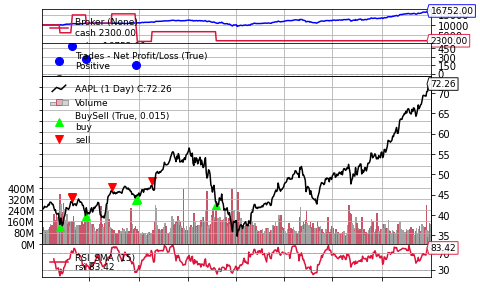

In [7]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(RSI)

        # Create a Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname='AAPL',
        # Do not pass values before this date
        fromdate=datetime.datetime(2018, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2019, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    cerebro.plot(iplot = False)